<a href="https://colab.research.google.com/github/ijethmal/SC3000/blob/main/MC-draft-cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Balancing a Pole on a Cart

## Installing dependencies:

In [8]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 45.3 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.

In [12]:
!pip uninstall numpy -y
!pip install numpy==1.26.0

Found existing installation: numpy 2.2.4
Uninstalling numpy-2.2.4:
  Successfully uninstalled numpy-2.2.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 91.1 MB/s eta 0:00:00


In [13]:
!pip uninstall jaxlib jax -y
!pip install jax jaxlib --upgrade

Found existing installation: jaxlib 0.5.3
Uninstalling jaxlib-0.5.3:
  Successfully uninstalled jaxlib-0.5.3
Found existing installation: jax 0.5.3
Uninstalling jax-0.5.3:
  Successfully uninstalled jax-0.5.3
  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached jax-0.5.3-py3-none-any.whl (2.4 MB)
Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl (105.1 MB)


## Importing dependencies and define helper functions

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from abc import ABC, abstractmethod
from typing import NamedTuple
import pickle
from collections import defaultdict

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


## Tutorial: Loading CartPole environment

In [4]:
env = gym.make("CartPole-v1")

The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [5]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [6]:
class Observation(NamedTuple):
    cart_pos: int
    cart_vel: int
    pole_angle: int
    pole_vel: int

def discretize_state(observation):
  #
    cart_pos_bins = np.linspace(-4.8, 4.8, 10)
    cart_vel_bins = np.linspace(-5, 5, 10)
    pole_angle_bins = np.linspace(-0.418, 0.418, 10)
    pole_vel_bins = np.linspace(-5, 5, 10)

    return Observation(
        np.digitize(observation[0], cart_pos_bins),
        np.digitize(observation[1], cart_vel_bins),
        np.digitize(observation[2], pole_angle_bins),
        np.digitize(observation[3], pole_vel_bins)
    )

## Task 1: Development of an RL agent

In Reinforcement Learning, we have an agent that interacts with the environment by performing an action (A) at each time step t. The environment then responds to the action with a new state (S) and reward (R). The agent takes the new state and reward into consideration when performing yet another action. The agent’s goal is to perform actions that will maximize the total reward it receives over the long run.

**Action Selection Strategy: Epsilon-Greedy**

How each action is chosen is defined within choose_action. The value of self-epsilon determines the amount of exploration and exploitation- so a self.epsilon = 0.2 would mean 20% exploration. If np.random.uniform(0,1) returns a value less than self.epsilon, the agent will explore - which means choose a random action.

If np.random.uniform(0,1) returns a value higher than self.epsilon, the agent will exploit - which means choose the action with the highest estimated Q-value. (explained below)

A high epsilon encourages more exploration, while a low epsilon favors exploiting the current best actions. The value of epsilon needs to be tuned for the specific problem, so we try different values to find the value that creates the best agent.

**Q-Value Updating**

*Return* refers to is a specific function of the discounted reward sequence with a discount rate 𝛾 (0 ≤ 𝛾 ≤ 1). The return G at time step t is calculated as follows:
```
G_t = R_{t+1} + γ * R_{t+2} + γ^2 * R_{t+3} + ...
```
A higher gamma value gives more weight to future rewards, and the limit is 1, at which point future rewards are just as important as immeidate rewards. If gamma is 0, the agent only considers immediate reward. In this code, we tried different values of gamma to find the optimal discount rate for this problem.

*Policy* is a mapping from states to the probabilities of selecting each possible action. The policy is what we want to learn and optimize so that it maximizes the expected return over the long run.

*Value Function* is a function that estimates the expected return starting from a given state (or state-action pair) and following a policy. This agent uses action-value function, or Q-function, which is a type of value function that estimates the value of taking a specific action (A) in a particular state (S).

How the agent works - it interacts with the environment, runs full episodes and after each episode, runs update_Q to update its Q-value estimates. The update rule in update_Q updates the Q-value of a state-action pair using the following formula:
```
`Q(s, a) = Q(s, a) + α * [R + γ * max_a' Q(s', a') - Q(s, a)]`
```
The formula updates Q-value of a state-action pair (Q(s,a)) based on the difference between the actual return (G) observed during an episode and the current estimated Q-value. The learning rate (alpha) controls the magnitude of this adjustment. This is **Monte Carlo Q-Evaluation**.






In [16]:
class MonteCarloAgent:
    def __init__(self, action_space_size, load_from_file=True, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.action_space_size = action_space_size
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.epsilon = epsilon  # exploration %
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # use defaultdict to dynamically store Q-values
        self.Q = defaultdict(lambda: 10)  # start with high Q-values??
        self.returns = defaultdict(list)
        self.N = defaultdict(int)
        #self.epsilon = 0.9
        #self.min_epsilon = 0.1
        #self.gamma = 0.99
        self.filename = "mc_q_table.pkl"

        # load Q-table if available
        if load_from_file:
            self.load_q_table()

    def save_q_table(self):
        with open(self.filename, "wb") as file:
            pickle.dump((dict(self.Q), dict(self.returns), dict(self.N)), file)

    def load_q_table(self):
        try:
            with open(self.filename, "rb") as file:
                self.Q, self.returns, self.N = pickle.load(file)
                self.Q = defaultdict(int, self.Q)
                self.returns = defaultdict(list, self.returns)
                self.N = defaultdict(int, self.N)
            #print("Q-table loaded.")
        except (EOFError, FileNotFoundError):
            print("No saved Q-table found. starting fresh.")

    def decay_epsilon(self):
      self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def reset_q_table(self):
      self.Q = defaultdict(lambda: 10)
      self.returns = defaultdict(list)
      self.N = defaultdict(int)
      self.save_q_table()

    def choose_action(self, state):
        # epsilon-greedy action selection
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(self.action_space_size) # explore
        else:
            return np.argmax([self.Q[(state, a)] for a in range(self.action_space_size)]) # exploit

    # update_Q will be called at the end of each episode. it takes the entire episode's experience as input
    # and calculates the return G for each state-action pair throughout the episode and accumulating the
    # rewards. Q-value for each state-action pair is updated using the calculated return G
    def update_Q(self, episode):
      G = 0
      visited_state_action_pairs = set()

      for t in reversed(range(len(episode))):
          state, action, reward = episode[t]
          G = self.gamma * G + reward

          # first-visit Monte Carlo
          if (state, action) not in visited_state_action_pairs:
              visited_state_action_pairs.add((state, action))
              self.returns[(state, action)].append(G)
              self.N[state, action] += 1

              # using running average for stability
              #self.Q[state, action] += (G - self.Q[state, action]) / self.N[state, action]
              # updating Q-value using the learning rate (alpha)
              self.Q[state, action] += self.alpha * (G - self.Q[state, action])

      self.save_q_table()  # save progress after every episode

Now, we train the agent, using varying hyperparameter values (alpha, gamma, epsilon).

np.linspace is used to create fine grids for alphas, gammas, and epsilons, providing many values to explore.

Each combination of hyperparameters runs 5 trials of 500 episodes and the results dictionary stores the average reward across trials for each hyperparameter combination.

We will then use the best hyperparameter combination to train a best agent.

In [17]:
alphas = np.linspace(0.01, 0.5, 3)  # lower to higher learning rate
gammas = np.linspace(0.9, 0.99, 3)  # lower to higher discount rate
epsilons = np.linspace(0.1, 1.0, 3)  # less to more exploration

num_trials = 3  # number of trials per combination
num_episodes = 300

results = {}

for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            trial_rewards = []
            for trial in range(num_trials):
              agent = MonteCarloAgent(env.action_space.n, alpha=alpha, gamma=gamma, epsilon=epsilon)
              agent.reset_q_table()
              for episode in range(num_episodes):
                  observation = env.reset()
                  episode = []
                  episode_rewards = []  # rewards for each episode within a trial
                  cumulative_reward = 0
                  done = False

                  while not done:
                      state = discretize_state(observation)
                      action = agent.choose_action(state)
                      observation, reward, done, info = env.step(action)

                      cart_pos, cart_vel, pole_angle, pole_vel = observation

                      # termination check
                      if abs(pole_angle) > 0.2094 or abs(cart_pos) > 2.4:
                          done = True

                      episode.append((state, action, reward))
                      cumulative_reward += reward

                  agent.update_Q(episode)
                  agent.decay_epsilon()
                  episode_rewards.append(cumulative_reward)  # rewards for episode

              trial_rewards.append(np.mean(episode_rewards))  # average reward for trial
              print(f"Trial {trial + 1} for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete.")

            results[(alpha, gamma, epsilon)] = np.mean(trial_rewards)  # average reward across trials
            print(f"Trials for alpha={alpha}, gamma={gamma}, epsilon={epsilon} complete. Average reward: {results[(alpha, gamma, epsilon)]}")


No saved Q-table found. starting fresh.
Trial 1 for alpha=0.01, gamma=0.9, epsilon=0.1 complete.
Trial 2 for alpha=0.01, gamma=0.9, epsilon=0.1 complete.
Trial 3 for alpha=0.01, gamma=0.9, epsilon=0.1 complete.
Trials for alpha=0.01, gamma=0.9, epsilon=0.1 complete. Average reward: 178.0
Trial 1 for alpha=0.01, gamma=0.9, epsilon=0.55 complete.
Trial 2 for alpha=0.01, gamma=0.9, epsilon=0.55 complete.
Trial 3 for alpha=0.01, gamma=0.9, epsilon=0.55 complete.
Trials for alpha=0.01, gamma=0.9, epsilon=0.55 complete. Average reward: 117.33333333333333
Trial 1 for alpha=0.01, gamma=0.9, epsilon=1.0 complete.
Trial 2 for alpha=0.01, gamma=0.9, epsilon=1.0 complete.
Trial 3 for alpha=0.01, gamma=0.9, epsilon=1.0 complete.
Trials for alpha=0.01, gamma=0.9, epsilon=1.0 complete. Average reward: 108.33333333333333
Trial 1 for alpha=0.01, gamma=0.9450000000000001, epsilon=0.1 complete.
Trial 2 for alpha=0.01, gamma=0.9450000000000001, epsilon=0.1 complete.
Trial 3 for alpha=0.01, gamma=0.9450000

In [18]:
best_params = max(results, key=results.get)  # Get the key with the max value
best_reward = results[best_params]  # Get the max value (reward)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Average Reward: {best_reward}")

Best Hyperparameters: (0.01, 0.99, 0.1)
Best Average Reward: 335.3333333333333


The best hyperparameters are as follows:

Alpha = 0.01, the lowest learning rate

Gamme = 0.99, the highest discount rate

Epsilon = 0.1, less exploration

Now, train the agent using the best combination of hyperparameters for 10000 episodes - or until best performance.

In [ ]:
env = gym.make("CartPole-v1")
agent = MonteCarloAgent(env.action_space.n, alpha=0.01, gamma=0.99, epsilon=0.1)
agent.reset_q_table()

#train
num_episodes = 10000
episode_results = []
episode_num = 0
consistent = False

while not consistent:
  observation = env.reset()
  episode = []
  cumulative_reward = 0
  done = False

  while not done:
      state = discretize_state(observation)
      action = agent.choose_action(state)
      observation, reward, done, info = env.step(action)

      cart_pos, cart_vel, pole_angle, pole_vel = observation

      # termination check based on constraints
      if abs(pole_angle) > 0.2094 or abs(cart_pos) > 2.4:
          done = True  # terminate episode

      episode.append((state, action, reward))
      cumulative_reward += reward

  agent.update_Q(episode)
  episode_num += 1

  agent.decay_epsilon()
  episode_results.append(cumulative_reward)
  if (episode_num+1) % 100 == 0:
    print(f"Episode {episode_num + 1}: Cumulative Reward = {cumulative_reward}")

  # if results = 500 for last 100 episodes, stop training
  if episode_num >= 100:
    score = episode_results[-100:]
    if np.mean(score) == 500:
      consistent = True
      print("Training stopped due to consistent performance.")


No saved Q-table found. starting fresh.


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100: Cumulative Reward = 256.0
Episode 200: Cumulative Reward = 45.0
Episode 300: Cumulative Reward = 211.0
Episode 400: Cumulative Reward = 171.0
Episode 500: Cumulative Reward = 173.0
Episode 600: Cumulative Reward = 200.0
Episode 700: Cumulative Reward = 500.0
Episode 800: Cumulative Reward = 199.0
Episode 900: Cumulative Reward = 500.0
Episode 1000: Cumulative Reward = 144.0
Episode 1100: Cumulative Reward = 232.0
Episode 1200: Cumulative Reward = 339.0
Episode 1300: Cumulative Reward = 169.0
Episode 1400: Cumulative Reward = 367.0
Episode 1500: Cumulative Reward = 500.0
Episode 1600: Cumulative Reward = 359.0
Episode 1700: Cumulative Reward = 144.0
Episode 1800: Cumulative Reward = 160.0
Episode 1900: Cumulative Reward = 114.0
Episode 2000: Cumulative Reward = 500.0
Episode 2100: Cumulative Reward = 167.0
Episode 2200: Cumulative Reward = 343.0
Episode 2300: Cumulative Reward = 159.0
Episode 2400: Cumulative Reward = 155.0
Episode 2500: Cumulative Reward = 147.0
Episode 26

## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [ ]:
# eval
eval_rewards = []
num_eval_episodes = 100

for episode_num in range(num_eval_episodes):
    observation = env.reset()
    episode_reward = 0
    done = False

    while not done:
      state = discretize_state(observation)
      action = agent.choose_action(state)
      observation, reward, done, info = env.step(action)
      episode_reward += reward

    eval_rewards.append(episode_reward)
    print(f"Evaluation Episode {episode_num + 1}: Reward = {episode_reward}")

Evaluation Episode 1: Reward = 417.0
Evaluation Episode 2: Reward = 219.0
Evaluation Episode 3: Reward = 500.0
Evaluation Episode 4: Reward = 69.0
Evaluation Episode 5: Reward = 500.0
Evaluation Episode 6: Reward = 71.0
Evaluation Episode 7: Reward = 500.0
Evaluation Episode 8: Reward = 500.0
Evaluation Episode 9: Reward = 500.0
Evaluation Episode 10: Reward = 500.0
Evaluation Episode 11: Reward = 36.0
Evaluation Episode 12: Reward = 500.0
Evaluation Episode 13: Reward = 500.0
Evaluation Episode 14: Reward = 69.0
Evaluation Episode 15: Reward = 500.0
Evaluation Episode 16: Reward = 284.0
Evaluation Episode 17: Reward = 500.0
Evaluation Episode 18: Reward = 47.0
Evaluation Episode 19: Reward = 261.0
Evaluation Episode 20: Reward = 273.0
Evaluation Episode 21: Reward = 333.0
Evaluation Episode 22: Reward = 500.0
Evaluation Episode 23: Reward = 500.0
Evaluation Episode 24: Reward = 500.0
Evaluation Episode 25: Reward = 500.0
Evaluation Episode 26: Reward = 500.0
Evaluation Episode 27: Rew

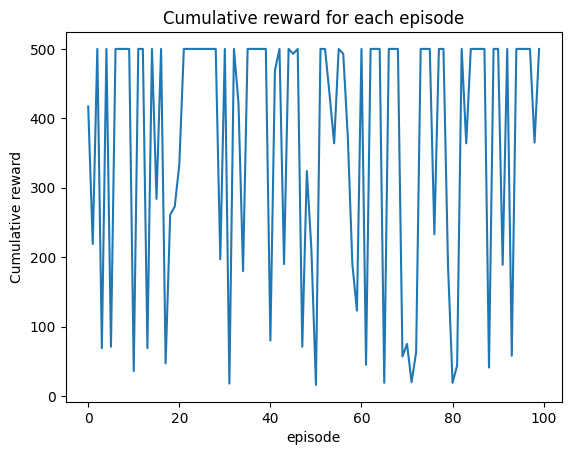

In [ ]:
plt.plot(eval_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
mean = sum(eval_rewards) / len(eval_rewards)
print(mean)

365.08


In [ ]:
print("Average cumulative reward:", mean)
print("Is my agent good enough?", mean > 195)

Average cumulative reward: 365.08
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [ ]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()

# Assuming you have already defined and trained your MonteCarloAgent (agent)
# and have state_space_size and action_space_size defined

# Initialize the agent here (if not already done)
agent = MonteCarloAgent(action_space_size=env.action_space.n)

while True:
    env.render()

    # Get the current state and discretize it
    state = discretize_state(observation)

    # Choose an action using the agent's policy
    action = agent.choose_action(state)

    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

Q-table loaded.


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
